In [1]:
import torch

In [4]:
torch.cuda.is_available()

True

In [3]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import scanpy as sc
import pandas as pd
import torch
import scipy
import time
from STEM.model import *
from STEM.utils import *
torch.cuda.empty_cache()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
scdata = pd.read_csv('./data/mousedata_2020/E1z2/simu_sc_counts.csv',index_col=0)
scdata = scdata.T
stdata = pd.read_csv('data/mousedata_2020/E1z2/simu_st_counts.csv',index_col=0)
stdata = stdata.T
stgtcelltype = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_celltype.csv',index_col=0)
spcoor = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_metadata.csv',index_col=0)
scmetadata = pd.read_csv('./data/mousedata_2020/E1z2/metadata.csv',index_col=0)

adata = sc.AnnData(scdata,obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

adata.obsm['spatial'] = scmetadata[['x_global','y_global']].values
stadata.obsm['spatial'] = spcoor

In [6]:
sc.pp.calculate_qc_metrics(adata,percent_top=None, log1p=False, inplace=True)
adata.obs['n_genes_by_counts'].median()

sc.pp.calculate_qc_metrics(stadata,percent_top=None, log1p=False, inplace=True)
stadata.obs['n_genes_by_counts'].median()

dp = 1- adata.obs['n_genes_by_counts'].median()/stadata.obs['n_genes_by_counts'].median()
dp

0.5836734693877551

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

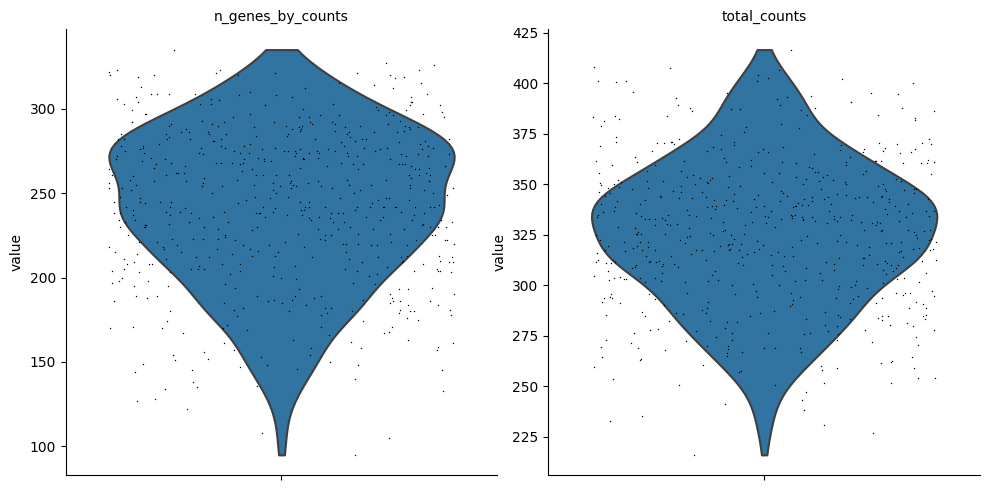

In [7]:
figsize(2,2)
sc.pl.violin(stadata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

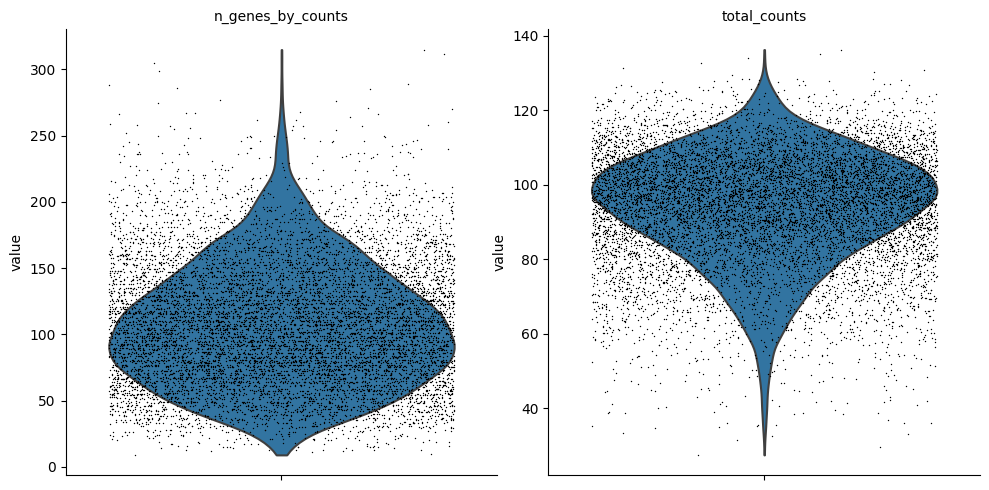

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

In [9]:
st_neighbor = scipy.spatial.distance.cdist(spcoor,spcoor)
sigma = 3
st_neighbor = np.exp(-st_neighbor**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)

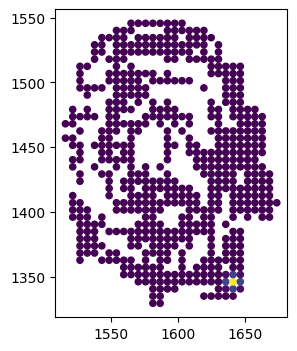

In [10]:
figsize(3,4)
plt.scatter(spcoor.values[:,0],spcoor.values[:,1],c=np.log1p(st_neighbor[30,:]),s=20)

In [11]:
class setting( object ):
    pass
seed_all(2022)
opt= setting()
setattr(opt, 'device', 'cuda:0')
setattr(opt, 'outf', 'log/Mouse_E1z2')
setattr(opt, 'n_genes', 351)
setattr(opt, 'no_bn', False)
setattr(opt, 'lr', 0.002)
setattr(opt, 'sigma', 3)
setattr(opt, 'alpha', 0.8)
setattr(opt, 'verbose', True)
setattr(opt, 'mmdbatch', 32)
setattr(opt, 'dp', dp)

In [12]:
%%time
testmodel = SOmodel(opt)
testmodel.togpu()
loss_curve = testmodel.train_wholedata(400,torch.tensor(scdata.values).float(),torch.tensor(stdata.values).float(),torch.tensor(spcoor.values).float())

[Train][0] Loss: E 3.651 E_pred 3.543 E_circle 5.132 E_mmd 0.135
[0.002]
[Train][1] Loss: E 5.129 E_pred 5.019 E_circle 5.249 E_mmd 0.138
[0.002]
[Train][2] Loss: E 4.620 E_pred 4.512 E_circle 5.117 E_mmd 0.134
[0.002]
[Train][3] Loss: E 3.472 E_pred 3.387 E_circle 4.623 E_mmd 0.106
[0.002]
[Train][4] Loss: E 3.654 E_pred 3.543 E_circle 4.591 E_mmd 0.140
[0.002]
[Train][5] Loss: E 3.364 E_pred 3.240 E_circle 4.523 E_mmd 0.155
[0.002]
[Train][6] Loss: E 3.651 E_pred 3.522 E_circle 4.704 E_mmd 0.162
[0.002]
[Train][7] Loss: E 3.362 E_pred 3.281 E_circle 4.614 E_mmd 0.101
[0.002]
[Train][8] Loss: E 3.177 E_pred 3.074 E_circle 4.065 E_mmd 0.129
[0.002]
[Train][9] Loss: E 3.212 E_pred 3.104 E_circle 4.121 E_mmd 0.135
[0.002]
[Train][10] Loss: E 3.128 E_pred 3.039 E_circle 4.043 E_mmd 0.111
[0.002]
[Train][11] Loss: E 3.125 E_pred 3.039 E_circle 4.104 E_mmd 0.107
[0.002]
[Train][12] Loss: E 3.129 E_pred 3.031 E_circle 4.033 E_mmd 0.122
[0.002]
[Train][13] Loss: E 3.023 E_pred 2.914 E_circle 

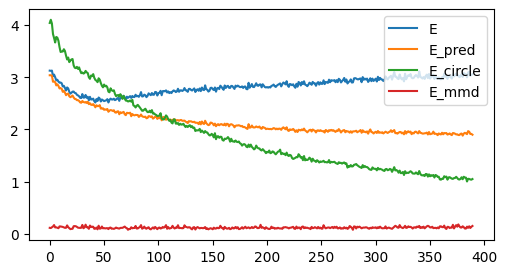

In [13]:
figsize(6,3)
skip=10
N = len(loss_curve['E'])-skip
plt.plot(np.arange(N),loss_curve['E'][skip:],label='E')
plt.plot(np.arange(N),loss_curve['E_pred'][skip:],label='E_pred')
plt.plot(np.arange(N),loss_curve['E_circle'][skip:],label='E_circle')
plt.plot(np.arange(N),loss_curve['E_mmd'][skip:],label='E_mmd')
plt.legend()

In [14]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()

In [15]:
np.save('result/230215_testdp_pure_mmd-E1z2.npy',netst2sc)
np.save('result/230215_testdp_pure_sc2st_mmd-E1z2.npy',netsc2st)
np.save('result/230215_scembbedding-E1z2.npy',scembedding.detach().cpu().numpy())
np.save('result/230215_stembbedding-E1z2.npy',stembedding.detach().cpu().numpy())

In [16]:
testmodel.save()

In [17]:
def all_coord(mappingmtx,spcoor):
    mappingnorm = mappingmtx.div(mappingmtx.sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.coord_x.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.coord_y.values)
    return spaotsc_coord

def k_coord(mappingmtx,spcoor, k=1):
    maskmap = np.zeros_like(mappingmtx)

    argmask = np.argsort(1/mappingmtx.values,axis=1)

    for i in range(argmask.shape[0]):
        for j in range(k):
            maskmap[i,argmask[i,j]]=1

    mappingnorm = (maskmap*mappingmtx).div((maskmap*mappingmtx).sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.coord_x.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.coord_y.values)
    return spaotsc_coord

In [18]:
adata.obsm['spatialDA'] = all_coord(pd.DataFrame(netsc2st,index=adata.obs_names,columns=stadata.obs_names),spcoor)

In [19]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

# Saliency Map

In [21]:
sc.settings.figdir = './result/'

## Spinalcoord

In [22]:
spinalcoorddata = scdata[(scmetadata['celltype_mapped_refined']=='Spinal cord')&(scmetadata.y_global>1410)].copy()
spinalcoorddata = torch.Tensor(spinalcoorddata.values).cuda()

spinalmetadata = scmetadata[scmetadata['celltype_mapped_refined']=='Spinal cord']
spinalmetadata = spinalmetadata[spinalmetadata.y_global>1410]

spinaladata = adata[(scmetadata['celltype_mapped_refined']=='Spinal cord')&(scmetadata.y_global>1410),:].copy()

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [23]:
def curve_length(x,y):
    x = np.linspace(0, y-x, 100)
    curve = a5*x**5+a4*x**4 + a3*x**3 + a2*x**2 +a1*x+a0
    return np.sum(np.sqrt(np.sum((curve[:-1] - curve[1:])**2,axis=1)))

In [24]:
spinalspcoor =  spinaladata.obsm['spatial']

a5,a4, a3,a2,a1,a0= np.polyfit(spinalspcoor[:,0],spinalspcoor[:,1],5)
fity = a5*spinalspcoor[:,0]**5+a4*spinalspcoor[:,0]**4 + a3*spinalspcoor[:,0]**3 + a2*spinalspcoor[:,0]**2 +a1*spinalspcoor[:,0]+a0

pseudotime = []
for i in range(spinalspcoor.shape[0]):
    pseudotime.append(curve_length(spinalspcoor[0,:],spinalspcoor[i,:]))

pseudotime = np.array(pseudotime)/1e8
pseudotime = (pseudotime.max() - pseudotime)/(pseudotime.max()-pseudotime.min())
# plt.savefig('nipsfig/embro_spinal_traj.png',bbox_inches='tight',dpi=330)
spinaladata.obs['pseudotime'] = pseudotime
spinaladata.obsm['pseudotime'] = np.expand_dims(np.array(pseudotime),1)

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


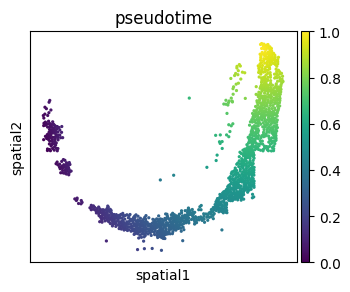

In [25]:
sc.pl.spatial(spinaladata,color='pseudotime',spot_size=2,basis='spatial')

In [26]:
sc.pp.neighbors(spinaladata,use_rep='pseudotime')
sc.tl.leiden(spinaladata,resolution=0.1)

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Administrator\AppData\Local

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


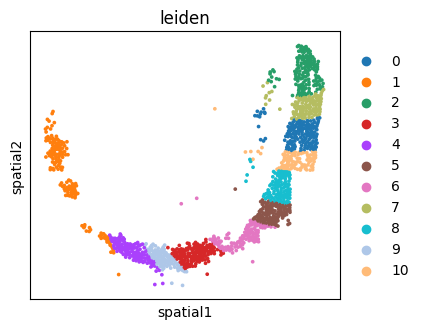

In [27]:
figsize(4,5)
sc.pl.spatial(spinaladata,color='leiden',spot_size=2,save='segments')

In [30]:
class Captummodel(nn.Module):
    def __init__(self, netE, stembedding):
        super(Captummodel, self).__init__()

        self.netE = netE
        self.netE.eval()
        self.stembedding = stembedding.t()

    def forward(self, x):
        x = self.netE(x)
        return x.mm(self.stembedding)
from captum.attr import IntegratedGradients

In [31]:
from tqdm import tqdm
capt = Captummodel(testmodel.netE,stembedding.detach())
capt.eval()


allsali = []
allbestidx = []
alldelta = []
allscemb = []
for i in tqdm(range(spinalcoorddata.shape[0])):
    inputdata = spinalcoorddata[i].unsqueeze(0)
    scembedding = testmodel.netE(inputdata)
    allscemb.append(scembedding.detach().cpu().numpy())
    spinal2st = scembedding.mm(stembedding.detach().t())
    idx = spinal2st.argmax()
    ig = IntegratedGradients(capt)
    attributions,delta = ig.attribute(inputdata,target=idx,return_convergence_delta=True)
    allsali.append(attributions.detach().cpu().numpy()[0])
    alldelta.append(delta.mean().item())
allsali = np.array(allsali)

100%|██████████████████████████████████████████████████████████████████████████████| 1416/1416 [00:17<00:00, 82.70it/s]


In [32]:
saliadata = sc.AnnData(pd.DataFrame(allsali,columns=scdata.columns,index = spinaladata.obs_names),obs = spinaladata.obs)
saliadata.obsm['spatial'] = spinaladata.obsm['spatial']
saliadata.obsm['spatialDA'] = spinaladata.obsm['spatialDA']

In [33]:
sc.tl.rank_genes_groups(saliadata,groupby='leiden',method='wilcoxon')

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  sel

In [34]:
sc.get.rank_genes_groups_df(saliadata,pval_cutoff =0.05,log2fc_min=0,group=None).names.unique().shape

(258,)

In [35]:
maxclt = saliadata.obs['leiden'].values.astype(int).max()
clusteridx =[]
for i in range(maxclt+1):
    clusteridx.append(saliadata.obs.loc[saliadata.obs['leiden']==str(i),'pseudotime'].mean())

a = np.arange(maxclt+1)
reclusterindex = [a for _,a in sorted(zip(clusteridx,a))]

In [36]:
import seaborn as sns
rkgene = pd.DataFrame(saliadata.uns['rank_genes_groups']['names'])
cellorder = saliadata.obs.sort_values('pseudotime').index
salidf = pd.DataFrame(saliadata[cellorder,:].X,index=saliadata[cellorder,:].obs.pseudotime.tolist(),columns=saliadata.var_names)

N=4
topgenelist = []
for i in reclusterindex:
    topgenelist += rkgene.iloc[:N,i].tolist()

sal_plotgenelist=[]
for x in topgenelist:
    if x not in sal_plotgenelist:
        sal_plotgenelist.append(x)
df = salidf.loc[:,sal_plotgenelist].T

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [37]:
plotsali = saliadata[cellorder,:].copy()
sc.pp.scale(plotsali)

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):


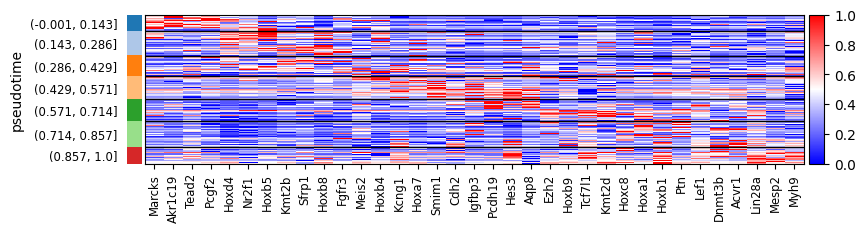

In [38]:
sc.pl.heatmap(plotsali,df.index.tolist(),groupby='pseudotime',cmap='bwr',swap_axes=False,standard_scale='obs',figsize=(9,2),save='spinal_traj_axis.pdf')

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


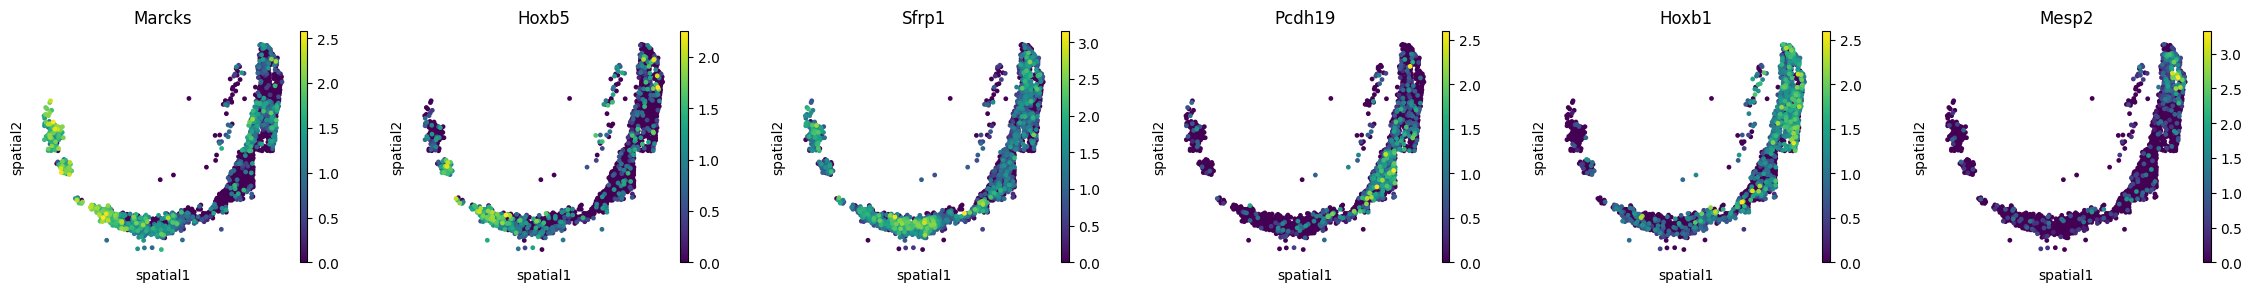

In [39]:
import matplotlib.colors as colors
figsize(3.8,3)
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.bottom'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.spatial(spinaladata,spot_size=3,color=['Marcks','Hoxb5','Sfrp1','Pcdh19','Hoxb1','Mesp2'],ncols=6,basis='spatial',save='trajectory_exrpession.pdf')

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


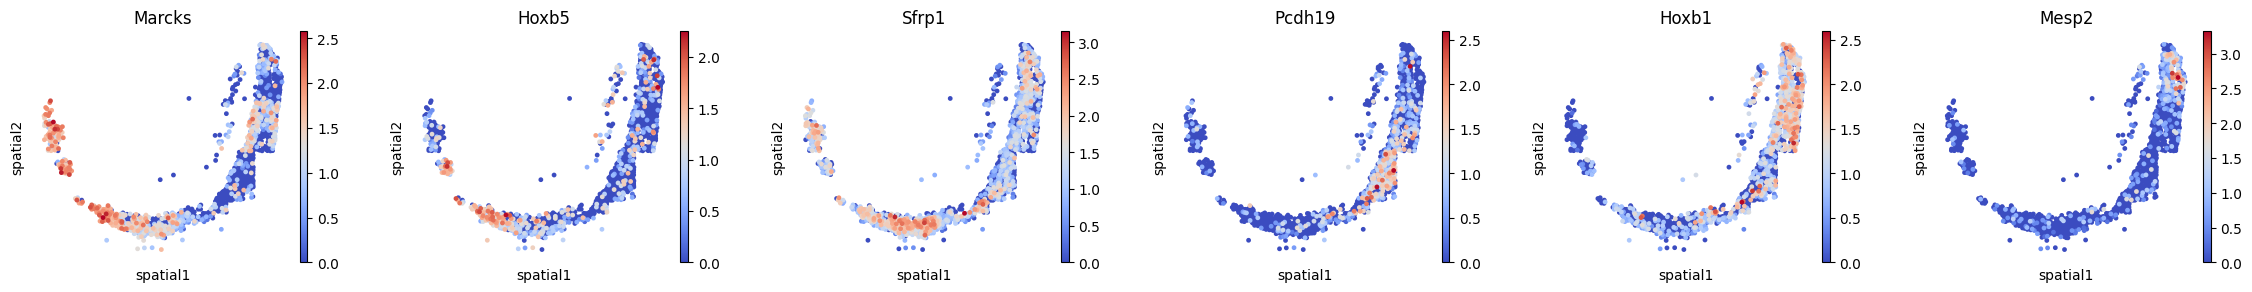

In [40]:
sc.pl.spatial(spinaladata,spot_size=3,color=['Marcks','Hoxb5','Sfrp1','Pcdh19','Hoxb1','Mesp2'],cmap='coolwarm',ncols=6,basis='spatial')

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


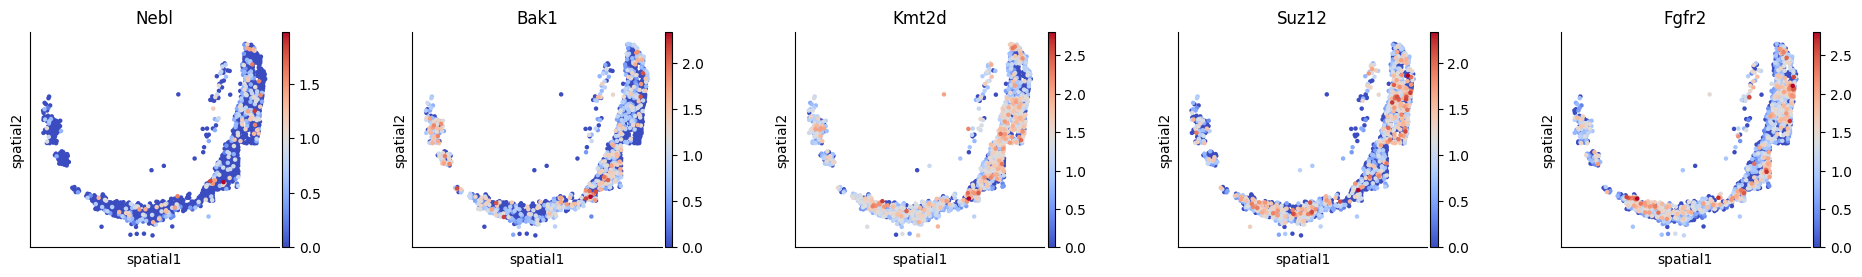

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


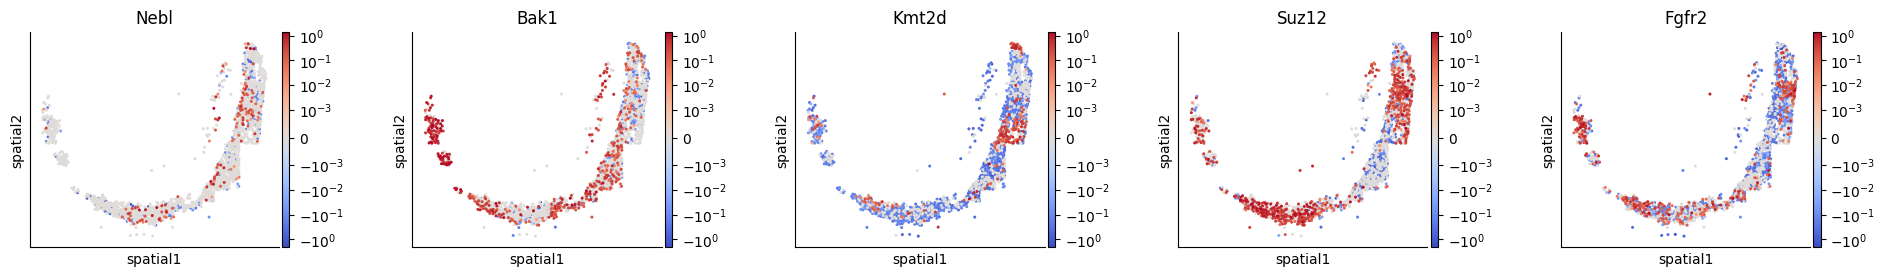

In [41]:
figsize(3.8,2.8)
rcParams['axes.spines.left'] = True
rcParams['axes.spines.bottom'] = True
sc.pl.spatial(spinaladata,spot_size=3,color=['Nebl','Bak1','Kmt2d','Suz12','Fgfr2'],ncols=6,cmap='coolwarm',basis='spatial',save='nonspatialsdg.pdf')
sc.pl.spatial(saliadata,spot_size=2,color=['Nebl','Bak1','Kmt2d','Suz12','Fgfr2'],ncols=6,cmap='coolwarm',basis='spatial',norm = colors.SymLogNorm(linthresh=0.001,base=10),save='nonspatialsdg-saliency.pdf')

## Forebrain/Midbrain/Hindbrain

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.

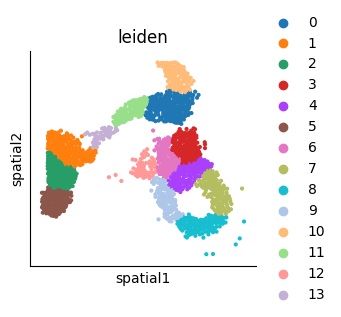

In [42]:
spinaladata = adata[scmetadata['celltype_mapped_refined']=='Forebrain/Midbrain/Hindbrain',:].copy()
spinaladata = spinaladata[spinaladata.obs['y_global']<1430].copy()
spinaladata = spinaladata[spinaladata.obs['x_global']<1630].copy()

sc.pp.neighbors(spinaladata,use_rep='spatial')
sc.tl.leiden(spinaladata,resolution=0.5)
sc.pl.spatial(spinaladata,color='leiden',spot_size=2,basis='spatial') 

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


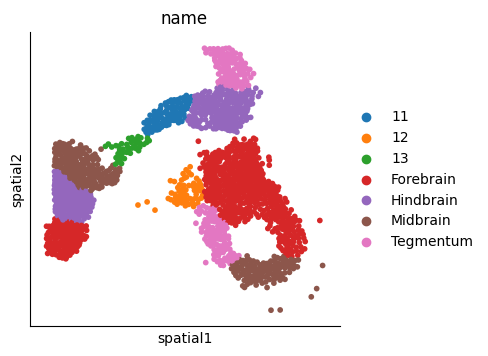

In [43]:

spinaladata.obs['name'] = spinaladata.obs['leiden'].copy().astype(str)
spinaladata.obs.loc[spinaladata.obs['leiden']=='0','name'] ='Hindbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='1','name'] ='Midbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='2','name'] ='Hindbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='3','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='4','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='5','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='6','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='7','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='8','name'] ='Midbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='9','name'] ='Tegmentum'
spinaladata.obs.loc[spinaladata.obs['leiden']=='10','name'] ='Tegmentum'
figsize(4,4)
sc.pl.spatial(spinaladata,color='name',spot_size=2,basis='spatial',save='embro_brainsep') 

In [44]:
# spinaladata = spinaladata[spinaladata.obs.name.isin(['Midbrain','Tegmentum']),:]
spinalcoorddata = np.array(spinaladata.X)
spinalmetadata = spinaladata.obs

In [45]:
from tqdm import tqdm
capt = Captummodel(testmodel.netE,stembedding.detach())
capt.eval()
spinalcoorddata = torch.Tensor(spinalcoorddata).cuda()

allsali = []
allbestidx = []
alldelta = []
allemb=[]
for i in tqdm(range(spinalcoorddata.shape[0])):
    inputdata = spinalcoorddata[i].unsqueeze(0)
    scembedding = testmodel.netE(inputdata)
    allemb.append(scembedding.detach().cpu().numpy())
    spinal2st = scembedding.mm(stembedding.detach().t())
    idx = spinal2st.argmax()
    ig = IntegratedGradients(capt)
    attributions,delta = ig.attribute(inputdata,target=idx,return_convergence_delta=True)
    # attributions, delta = nt.attribute(inputdata,baselines= torch.rand_like(inputdata)*0.01,nt_type='smoothgrad', stdevs=0.02, nt_samples=5, target=idx, return_convergence_delta=True)
    allsali.append(attributions.detach().cpu().numpy()[0])
    alldelta.append(delta.mean().item())

allsali = np.array(allsali)

100%|██████████████████████████████████████████████████████████████████████████████| 1703/1703 [00:20<00:00, 82.77it/s]


In [46]:
saliadata = sc.AnnData(pd.DataFrame(allsali,columns=scdata.columns,index = spinaladata.obs_names),obs = spinaladata.obs)
saliadata.obsm['spatial'] = spinaladata.obsm['spatial']
saliadata.obsm['spatialDA'] = spinaladata.obsm['spatialDA']

In [47]:
allscemb =np.squeeze(np.array(allemb))
embadata = sc.AnnData(pd.DataFrame(allscemb,index = spinaladata.obs_names),obs = spinaladata.obs)
embadata.obsm['spatial'] = spinaladata.obsm['spatial']
embadata.obsm['spatialDA'] = spinaladata.obsm['spatialDA']
sc.pp.neighbors(embadata,use_rep='X',metric='cosine')
sc.tl.umap(embadata)

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


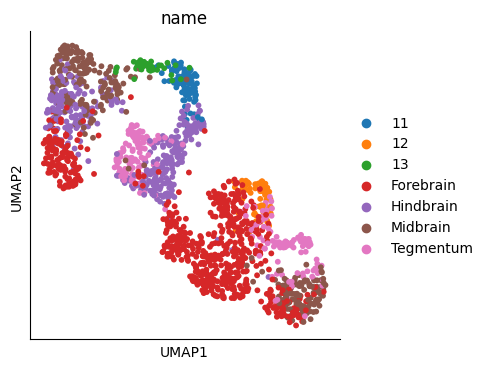

In [48]:
sc.pl.umap(embadata,color=['name'],save='embro_brainsep_emb')

In [49]:
clsspinaladata = spinaladata.copy()
sc.pp.scale(clsspinaladata)
sc.pp.pca(clsspinaladata)
sc.pp.neighbors(clsspinaladata)
sc.tl.umap(clsspinaladata)

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


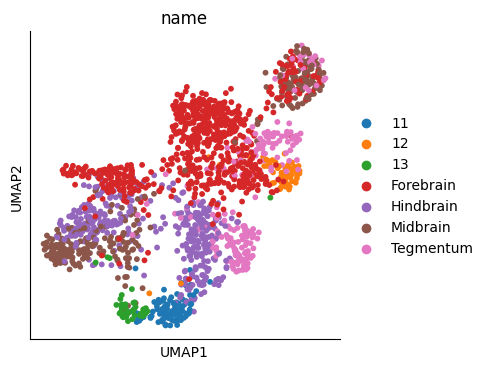

In [50]:
sc.pl.umap(clsspinaladata,color=['name'],save='embro_brainsep_raw')

# Search Sigma

In [ ]:
sc_gtcoord = scmetadata[['x_global','y_global']]
true_sc2sc = scipy.spatial.distance.cdist(sc_gtcoord,sc_gtcoord)
true_argmask = np.argsort(true_sc2sc,axis=1)

In [ ]:
class setting( object ):
    pass
seed_all(2022)
krgc={}
allloss = {}
for sig in np.arange(0,10,1).tolist():
    opt= setting()
    setattr(opt, 'device', 'cuda:0')
    setattr(opt, 'outf', 'log/Mouse_E1z2—sigma-search')
    setattr(opt, 'n_genes', 351)
    setattr(opt, 'no_bn', False)
    setattr(opt, 'lr', 0.002)
    setattr(opt, 'sigma', sig)
    setattr(opt, 'alpha', 0.8)
    setattr(opt, 'verbose', False)
    setattr(opt, 'mmdbatch', 1000)
    setattr(opt, 'dp', dp)

    testmodel = SOmodel(opt)
    testmodel.togpu()
    loss_curve = testmodel.train_wholedata(400,torch.tensor(scdata.values).float(),torch.tensor(stdata.values).float(),torch.tensor(spcoor.values).float())
    testmodel.modeleval()
    scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
    scembedding = scembedding.detach().cpu().numpy()
    sc2sc = np.matmul(scembedding,scembedding.T)
    argmask = np.argsort(-sc2sc,axis=1)
    krg = []
    for k in range(1,26):
        k_list = []
        for i in range(argmask.shape[0]):
            k_list.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
        krg.append(np.mean(k_list))
    allloss['sig_'+str(sig)] = loss_curve
    krgc['sig_'+str(sig)] = krg

In [ ]:
pd.DataFrame(krgc).to_csv('./result/sigma_MouseE1z2.csv')

In [ ]:
import pickle
with open('./result/sigma_MouseE1z2_loss.pkl','wb') as f:
    pickle.dump(loss_curve,f)

In [ ]:
import seaborn as sns
figsize(6,4)
ax = sns.lineplot(data = pd.DataFrame(krgc))
plt.xlabel('neighbor K')
plt.ylabel('hit number')

In [ ]:
pd.DataFrame(krgc)